In [40]:
# Core typing for the graph state (shared memory)
from typing import TypedDict, Optional

# LangGraph for workflow orchestration
from langgraph.graph import StateGraph, END

# LangChain components
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Hugging Face transformers pipeline
from transformers import pipeline





In [16]:
# Define the Shared Graph State
# Each agent will update part of the shared GraphState.
# This acts as the communication medium among agents.

class GraphState(TypedDict, total=False):
    query: str
    expression: Optional[str]
    search_result: Optional[str]
    calc_result: Optional[str]
    summary: Optional[str]


In [17]:
#Initialize the Language Model

hf_gen = pipeline(
    "text-generation",
    model="mistralai/Mistral-7B-Instruct-v0.2",  # or 'google/flan-t5-base'
    max_new_tokens=128,
    temperature=0.3
)

# Wrap in a LangChain-compatible LLM interface
llm = HuggingFacePipeline(pipeline=hf_gen)


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 28.86it/s]
Device set to use mps:0
/var/folders/36/c6m7q9gx4njbdgdy1y3mj9gm0000gn/T/ipykernel_45532/3403373334.py:8: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=hf_gen)


In [43]:
#This agent mimics a web search and returns a mock result.
#In real-world cases, you could replace this with a DuckDuckGo or Tavily API search.

def search_agent(state: GraphState):
    query = state["query"]
    print(f" [Search Agent] Simulating search for: {query}")
    mock_results = {
        "Germany GDP 2023": "Germany's GDP in 2023 was approximately 4.5 trillion USD.",
        "France GDP 2023": "France's GDP in 2023 was approximately 3.0 trillion USD."
    }
    return {"search_result": mock_results.get(query, f"No data found for {query}")}


In [44]:

# Define prompt for the calculator
calc_prompt = PromptTemplate.from_template("Calculate the result of: {expression}")

def calculator_agent(state: GraphState):
    expression = state.get("expression", "")
    print(f"[Calculator Agent] Calculating: {expression}")
    
    # Create LLMChain for computation
    chain = LLMChain(llm=llm, prompt=calc_prompt)
    
    result = chain.run(expression=expression)
    return {"calc_result": result}



In [45]:
def summarizer_agent(state: GraphState):
    print("[Summarizer Agent] Summarizing results...")

      # Combine all text from previous agents
    text = f"{state.get('search_result', '')}\n{state.get('calc_result', '')}"

        # Create summarization prompt
    prompt = PromptTemplate.from_template("Summarize this briefly:\n{input_text}")  # variable name = input_text
    chain = LLMChain(llm=llm, prompt=prompt)
    summary = chain.run(input_text=text)  # matches input_text
    return {"summary": summary}




In [46]:
workflow = StateGraph(GraphState)

# Define agent nodes
workflow.add_node("search", search_agent)
workflow.add_node("calculator", calculator_agent)
workflow.add_node("summarizer", summarizer_agent)

# Define edges (execution flow)
workflow.set_entry_point("search")
workflow.add_edge("search", "calculator")
workflow.add_edge("calculator", "summarizer")
workflow.add_edge("summarizer", END)

# Compile the workflow
graph = workflow.compile()



In [47]:
input_state = {
    "query": "Germany GDP 2023",
    "expression": "5% of 4.5 trillion USD"
}

result = graph.invoke(input_state)
print("\n Final Summary:\n", result["summary"])


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 [Search Agent] Simulating search for: Germany GDP 2023
[Calculator Agent] Calculating: 5% of 4.5 trillion USD


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[Summarizer Agent] Summarizing results...

 Final Summary:
 Summarize this briefly:
Germany's GDP in 2023 was approximately 4.5 trillion USD.
Calculate the result of: 5% of 4.5 trillion USD

To calculate 5% of 4.5 trillion USD, you can follow these steps:

1. Convert the trillions to decimal form. Since 1 trillion = 1,000,000,000,000, 4.5 trillion equals 4,500,000,000,000.
2. Multiply the number by the percentage as a decimal. In this case, 5% equals 0.05.
3. Multiply: 4,500,000,000,000 × 0.05

Now let's calculate:

4,500,000,000,000 × 0.05 = 225,000,000,000,000

So, 5% of 4.5 trillion USD is 225 quadrillion USD.


/Users/swatichandna/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


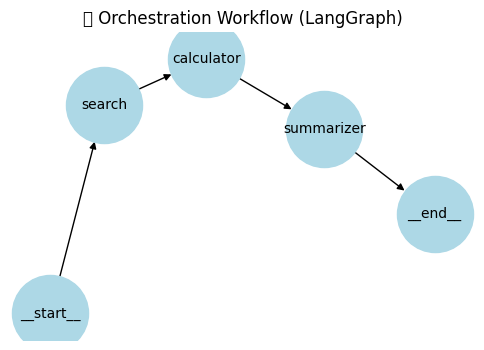

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

# Retrieve the internal graph safely
g_obj = graph.get_graph()

# Try to detect the correct way to access edges
edges = []
try:
    edges = g_obj.edges
except Exception:
    try:
        edges = g_obj.edges()
    except Exception:
        pass

# Convert to a proper NetworkX DiGraph
nx_graph = nx.DiGraph()
for edge in edges:
    # Each edge should be a (source, target) tuple
    if isinstance(edge, (tuple, list)) and len(edge) >= 2:
        nx_graph.add_edge(edge[0], edge[1])

# --- Draw using matplotlib ---
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(nx_graph, seed=42)
nx.draw_networkx(
    nx_graph,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=3000,
    font_size=10,
    arrows=True
)
plt.title("Orchestration Workflow (LangGraph)")
plt.axis("off")
plt.show()
